In [8]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from keras import layers
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import metrics
from keras.applications.densenet import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# Set the path to your dataset
BASE_PATH_TRAIN = "C:\\kaggle\\input\\ArTaxOr"
BASE_PATH_TEST = "C:\\DL Testing Set"

#BASE_PATH_TRAIN = "C:\\DL Testing Set"
#BASE_PATH_TEST = "C:\\kaggle\\input\\ArTaxOr"


# Step 1: Image Preprocessing
image_train = []
labels_train = []

for root, dirs, files in os.walk(BASE_PATH_TRAIN):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_train.append(os.path.join(root, file))
                labels_train.append(label)

data_train = {'Images': image_train, 'labels': labels_train}
data_train = pd.DataFrame(data_train)

lb = LabelEncoder()
data_train['encoded_labels'] = lb.fit_transform(data_train['labels'])

image_test = []
labels_test = []

for root, dirs, files in os.walk(BASE_PATH_TEST):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image_test.append(os.path.join(root, file))
                labels_test.append(label)

data_test = {'Images': image_test, 'labels': labels_test}
data_test = pd.DataFrame(data_test)

data_test['encoded_labels'] = lb.transform(data_test['labels'])



In [10]:
# Number of classes (insects)
num_classes = len(lb.classes_)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create data generator
batch_size = 64



In [11]:
# Define a data generator for training and validation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Define a data generator for testing
test_gen = ImageDataGenerator(rescale=1./255.)

# Training Data Generator

train_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="training",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)

# Validation Data Generator
val_generator = datagen.flow_from_dataframe(
    dataframe=data_train,
    x_col="Images",
    y_col="labels",
    subset="validation",
    batch_size=batch_size,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=(224, 224)
)



Found 12301 validated image filenames belonging to 7 classes.
Found 3075 validated image filenames belonging to 7 classes.


In [5]:
# Step 2: Model Modification for Insect Classification using DenseNet121

def get_densenet_model(num_classes):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model

densenet_model = get_densenet_model(num_classes)

In [6]:
# Compile the model

densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()]
)


# Train the model
history_densenet = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[EarlyStopping(patience=3)]
)

# Save the model
densenet_model.save("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_densenet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/artxdensenet_history.csv", index=False)

Epoch 1/10
193/193 [==============================] - 3649s 19s/step - loss: 1.3069 - accuracy: 0.5003 - recall: 0.3323 - precision: 0.6783 - auc: 0.8514 - val_loss: 5.0987 - val_accuracy: 0.0878 - val_recall: 0.0585 - val_precision: 0.1905 - val_auc: 0.1945
Epoch 2/10
193/193 [==============================] - 1925s 10s/step - loss: 0.9699 - accuracy: 0.6377 - recall: 0.5012 - precision: 0.7661 - auc: 0.9208 - val_loss: 5.1203 - val_accuracy: 0.1281 - val_recall: 0.0982 - val_precision: 0.3066 - val_auc: 0.2201
Epoch 3/10
193/193 [==============================] - 1919s 10s/step - loss: 0.9038 - accuracy: 0.6668 - recall: 0.5400 - precision: 0.7816 - auc: 0.9314 - val_loss: 5.3298 - val_accuracy: 0.1109 - val_recall: 0.0849 - val_precision: 0.2157 - val_auc: 0.2161
Epoch 4/10
193/193 [==============================] - 8201s 43s/step - loss: 0.8555 - accuracy: 0.6849 - recall: 0.5612 - precision: 0.7938 - auc: 0.9387 - val_loss: 5.3939 - val_accuracy: 0.1141 - val_recall: 0.0901 - val_

# Plot Loss and Accuracy

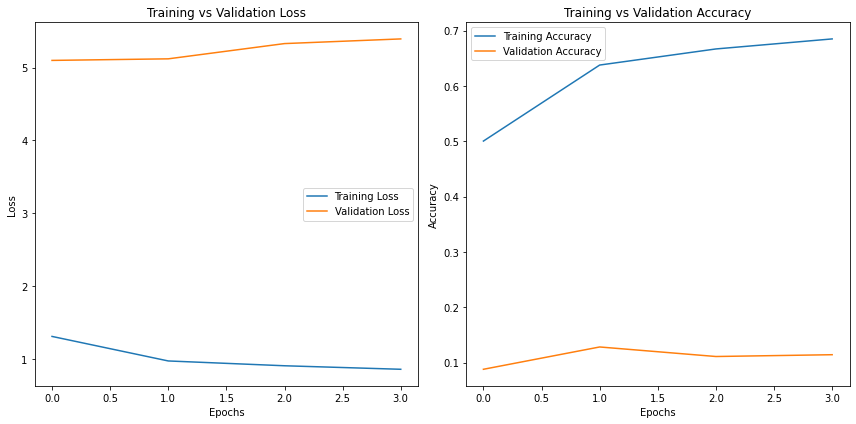

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/artxdensenet_history.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


# Remove Early Stopping

In [8]:
# Compile the model
densenet_model = get_densenet_model(num_classes)

densenet_model.compile(
    loss="categorical_crossentropy",
    optimizer=SGD(learning_rate=0.001, momentum=0.9),
    metrics=['accuracy', metrics.Recall(), metrics.Precision(), metrics.AUC()]
)


# Train the model
history_densenet = densenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
    #,callbacks=[EarlyStopping(patience=3)]
)

# Save the model
densenet_model.save("C:/Deep Learning/Project/Classification Models/artxdensenet_modelv2.h5")

# Save training history to a CSV file
history_df = pd.DataFrame(history_densenet.history)
history_df.to_csv("C:/Deep Learning/Project/Classification Models/artxdensenet_historyv2.csv", index=False)

Epoch 1/10
193/193 [==============================] - 3101s 16s/step - loss: 1.2853 - accuracy: 0.5109 - recall_1: 0.3404 - precision_1: 0.6769 - auc_1: 0.8567 - val_loss: 5.4212 - val_accuracy: 0.1132 - val_recall_1: 0.0725 - val_precision_1: 0.2264 - val_auc_1: 0.1963
Epoch 2/10
193/193 [==============================] - 2012s 10s/step - loss: 0.9667 - accuracy: 0.6345 - recall_1: 0.5008 - precision_1: 0.7616 - auc_1: 0.9214 - val_loss: 5.5554 - val_accuracy: 0.1138 - val_recall_1: 0.0833 - val_precision_1: 0.2248 - val_auc_1: 0.2018
Epoch 3/10
193/193 [==============================] - 1741s 9s/step - loss: 0.9038 - accuracy: 0.6640 - recall_1: 0.5400 - precision_1: 0.7807 - auc_1: 0.9314 - val_loss: 5.6241 - val_accuracy: 0.1350 - val_recall_1: 0.1086 - val_precision_1: 0.2670 - val_auc_1: 0.2212
Epoch 4/10
193/193 [==============================] - 2318s 12s/step - loss: 0.8608 - accuracy: 0.6799 - recall_1: 0.5621 - precision_1: 0.7889 - auc_1: 0.9378 - val_loss: 5.7196 - val_acc

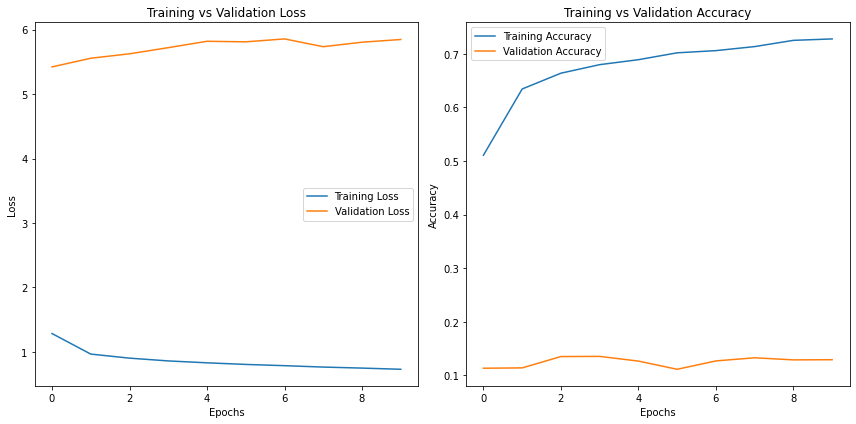

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data from the CSV file
file_path = "C:/Deep Learning/Project/Classification Models/artxdensenet_historyv2.csv"  # Update with the correct file path
history_data = pd.read_csv(file_path)

# Plot Training vs Validation Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_data['loss'], label='Training Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Training vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_data['accuracy'], label='Training Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Removing Early Stopping didn't improve Validation Accuracy so will use original model

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")
loaded_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# Test accuracy with Mobile Corpus

In [11]:
# Test accuracy
test_generator = datagen.flow_from_dataframe(
    dataframe=data_test,
    x_col="Images",
    y_col="labels",
    batch_size=batch_size,
    seed=42,
    shuffle=False,
    class_mode="categorical",
    target_size=(224, 224)
)

# Evaluate the model on the test set
test_results = loaded_model.evaluate(test_generator)

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


Found 14370 validated image filenames belonging to 7 classes.
225/225 [==============================] - 7205s 32s/step - loss: 2.8272 - accuracy: 0.4530 - recall: 0.3647 - precision: 0.6406 - auc: 0.6388
DenseNet Test Loss: 2.8272194862365723
DenseNet Test Accuracy: 0.45295754075050354


# Test Accuracy with Mobile Corpus

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Test Accuracy with Mobile ArTaxOr Corpus

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
Found 229 images belonging to 7 classes.
4/4 [==============================] - 43s 9s/step - loss: 1.6332 - accuracy: 0.6114 - recall: 0.5022 - precision: 0.7325 - auc: 0.8309
Found 229 images belonging to 7 classes.
4/4 [==============================] - 45s 9s/step
DenseNet Test Loss: 1.6331716775894165
DenseNet Test Accuracy: 0.6113536953926086
1/1 [==============================] - 0s 387ms/step


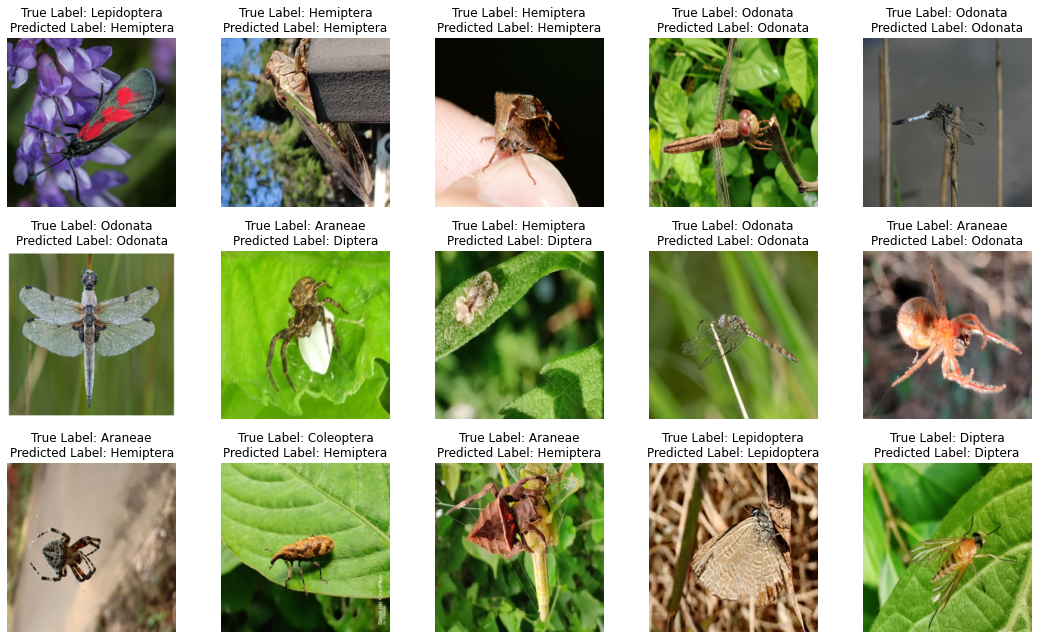

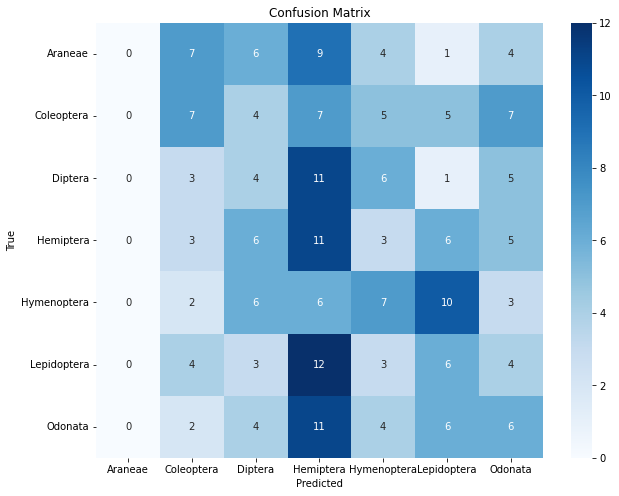

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.00      0.00      0.00        31
  Coleoptera       0.25      0.20      0.22        35
     Diptera       0.12      0.13      0.13        30
   Hemiptera       0.16      0.32      0.22        34
 Hymenoptera       0.22      0.21      0.21        34
 Lepidoptera       0.17      0.19      0.18        32
     Odonata       0.18      0.18      0.18        33

    accuracy                           0.18       229
   macro avg       0.16      0.18      0.16       229
weighted avg       0.16      0.18      0.17       229



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# Testing with Small DL Set

          labels  encoded_labels
0        Araneae               0
15    Coleoptera               1
35       Diptera               2
50     Hemiptera               3
69   Hymenoptera               4
88   Lepidoptera               5
103      Odonata               6
Found 118 images belonging to 7 classes.
2/2 [==============================] - 42s 16s/step - loss: 1.6998 - accuracy: 0.5593 - recall: 0.4407 - precision: 0.7222 - auc: 0.8151
Found 118 images belonging to 7 classes.
2/2 [==============================] - 40s 18s/step
DenseNet Test Loss: 1.6998339891433716
DenseNet Test Accuracy: 0.5593220591545105
1/1 [==============================] - 0s 248ms/step


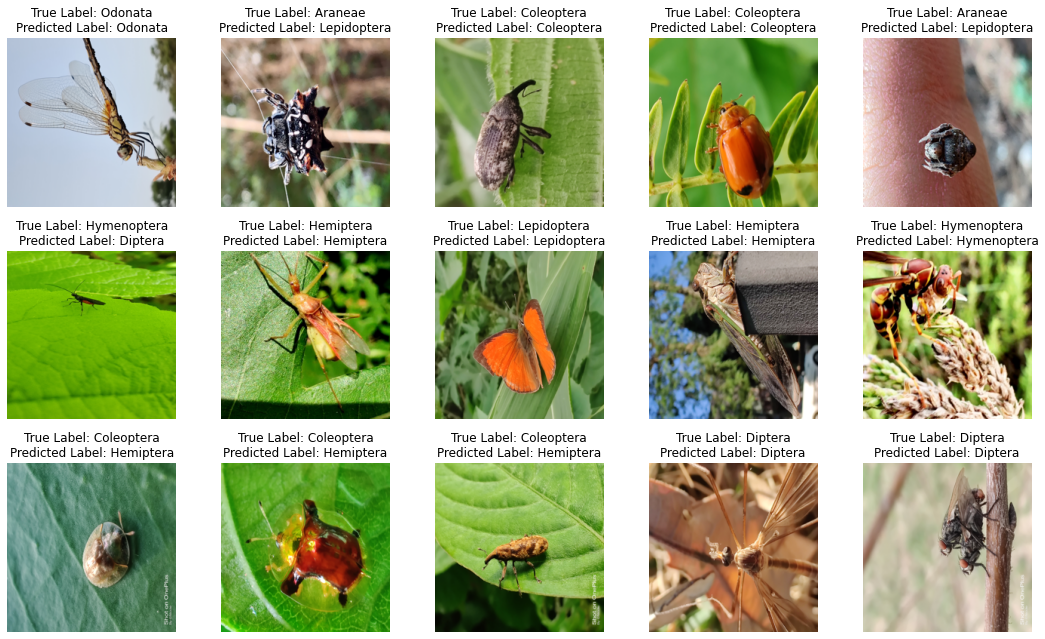

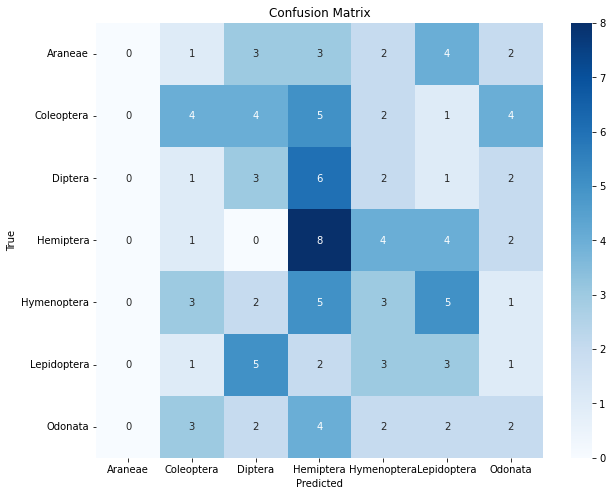

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.00      0.00      0.00        15
  Coleoptera       0.29      0.20      0.24        20
     Diptera       0.16      0.20      0.18        15
   Hemiptera       0.24      0.42      0.31        19
 Hymenoptera       0.17      0.16      0.16        19
 Lepidoptera       0.15      0.20      0.17        15
     Odonata       0.14      0.13      0.14        15

    accuracy                           0.19       118
   macro avg       0.16      0.19      0.17       118
weighted avg       0.17      0.19      0.18       118



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Set"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()


# Test Accuracy with ArTaxOR

            labels  encoded_labels
0          Araneae               0
2418    Coleoptera               1
4528       Diptera               2
6558     Hemiptera               3
8945   Hymenoptera               4
10993  Lepidoptera               5
13099      Odonata               6
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 2089s 9s/step - loss: 1.6834 - accuracy: 0.6021 - recall: 0.4946 - precision: 0.7591 - auc: 0.8182
Found 15376 images belonging to 7 classes.
241/241 [==============================] - 1742s 7s/step
DenseNet Test Loss: 1.6834295988082886
DenseNet Test Accuracy: 0.6021071672439575
1/1 [==============================] - 0s 119ms/step


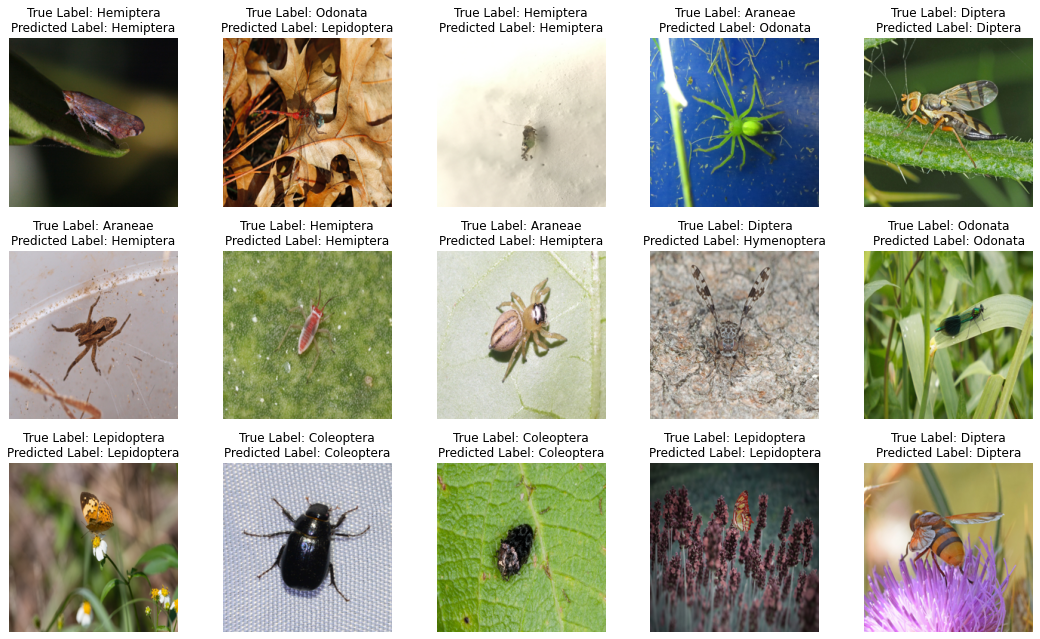

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import load_model


# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path
image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]



# Retrieve true labels from the data dataframe
true_labels = []

# Create a list of indices and shuffle it
indices = list(range(len(data)))
np.random.shuffle(indices)

for i in range(15):  # Select 15 random images
    random_index = indices[i]
    img_name = data.iloc[random_index]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    true_labels.append(true_label)

# Convert the true labels to numpy array
true_labels = np.array(true_labels)

# Evaluate the model on the test set and make predictions
test_results = loaded_model.evaluate(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))
predictions = loaded_model.predict(test_gen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'))

# Display the evaluation results
print("DenseNet Test Loss:", test_results[0])
print("DenseNet Test Accuracy:", test_results[1])


# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Create a 3x5 subplot grid
fig, axs = plt.subplots(3, 5, figsize=(15, 9))
fig.tight_layout()

# Loop over the selected random images
for i in range(len(true_labels)):
    img_name = data.iloc[indices[i]]['Images']
    img_path = os.path.join(BASE_PATH, data.iloc[indices[i]]['labels'], img_name)
    true_label = lb.inverse_transform([true_labels[i]])[0]

    # Load and preprocess the image
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)

    # Convert the prediction to a class label
    predicted_label = lb.inverse_transform(img_prediction.argmax(axis=1))[0]

    # Plot the image along with true and predicted labels
    axs[i // 5, i % 5].imshow(img)
    axs[i // 5, i % 5].axis('off')
    axs[i // 5, i % 5].set_title(f"True Label: {true_label}\nPredicted Label: {predicted_label}")

# Show the plot
plt.show()



# Confusion Matrices

## Mobile-ArTaxOR Mix set

          labels  encoded_labels
0        Araneae               0
31    Coleoptera               1
66       Diptera               2
96     Hemiptera               3
130  Hymenoptera               4
164  Lepidoptera               5
196      Odonata               6
1/1 [==============================] - 0s 114ms/step


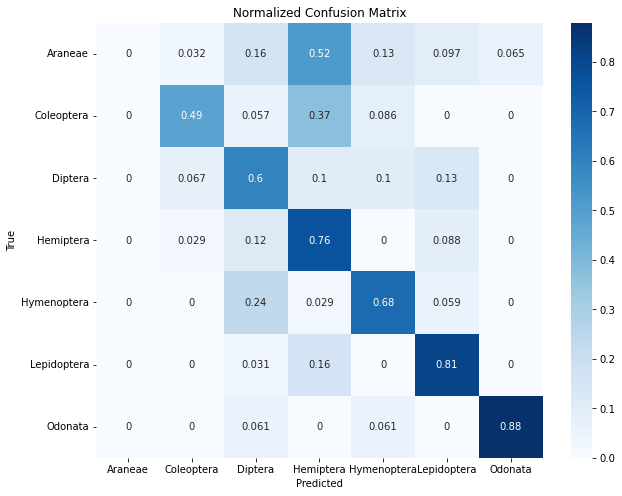

Classification Report:
              precision    recall  f1-score   support

     Araneae       0.00      0.00      0.00        31
  Coleoptera       0.81      0.49      0.61        35
     Diptera       0.45      0.60      0.51        30
   Hemiptera       0.41      0.76      0.53        34
 Hymenoptera       0.66      0.68      0.67        34
 Lepidoptera       0.68      0.81      0.74        32
     Odonata       0.94      0.88      0.91        33

    accuracy                           0.61       229
   macro avg       0.56      0.60      0.57       229
weighted avg       0.57      0.61      0.57       229



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Small Artax_Mobl Mix"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

# ArTaxOr

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\kaggle\\input\\ArTaxOr"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))

# Mobile Corpus

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.models import load_model
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model later if needed
loaded_model = load_model("C:/Deep Learning/Project/Classification Models/artxdensenet_model.h5")

# Set the path to the test set
test_dir = "C:\\DL Testing Set"  # Change this to the correct path

# Load the data dataframe
BASE_PATH = "C:\\DL Testing Set"  # Change this to the correct path

image = []
labels = []

for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".jpg"):
            label = os.path.basename(root)
            if label != 'annotations':
                image.append(file)
                labels.append(label)

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)

lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

unique_labels = data[['labels', 'encoded_labels']].drop_duplicates()
print(unique_labels)

# Define batch size
batch_size = 64

# Create a new column for file paths
data['filepaths'] = [os.path.join(BASE_PATH, row['labels'], row['Images']) for _, row in data.iterrows()]

# Retrieve true labels and predictions for the entire test set
true_labels = []
predicted_labels = []

# Loop over the entire test set
for i in range(len(data)):
    img_name = data.iloc[i]['Images']
    true_label = data[data['Images'] == img_name]['encoded_labels'].values[0]
    
    # Load and preprocess the image
    img_path = os.path.join(BASE_PATH, data.iloc[i]['labels'], img_name)
    img = Image.open(img_path)
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Make predictions on the image
    img_prediction = loaded_model.predict(img_array)
    predicted_label = np.argmax(img_prediction)

    true_labels.append(true_label)
    predicted_labels.append(predicted_label)

# Convert the lists to NumPy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Create a confusion matrix for the entire test set
cm = confusion_matrix(true_labels, predicted_labels)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap of the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=unique_labels['labels'], yticklabels=unique_labels['labels'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print the classification report for the entire test set
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=unique_labels['labels']))